In [30]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit.algorithms.optimizers import COBYLA, SPSA, L_BFGS_B
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime
from qiskit.utils import algorithm_globals

In [31]:
num_assets = 6
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2017, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [32]:
mu = [-1.1734e-03, 1.2696e00, 4.3733e-01, 7.6221e-02, 2.3281e-02, 8.1355e-01]
sigma = np.array(
    [
        [3.8891e-03, -3.0224e-02, 2.0261e-03, 5.6387e-04, 8.3185e-03, 1.9666e-02],
        [-3.0224e-02, 1.0839e02, 1.3541e01, -2.3283e-01, -2.0257e-01, 1.4126e01],
        [2.0261e-03, 1.3541e01, 1.2007e01, -9.7126e-02, -4.4600e-02, 4.3367e00],
        [5.6387e-04, -2.3283e-01, -9.7126e-02, 1.4255e00, 1.6567e-02, -5.6537e-02],
        [8.3185e-03, -2.0257e-01, -4.4600e-02, 1.6567e-02, 5.3393e-02, -1.8909e-02],
        [1.9666e-02, 1.4126e01, 4.3367e00, -5.6537e-02, -1.8909e-02, 3.0492e01],
    ]
)

In [33]:
def QUBO_from_portfolio(cov, mean, q, B, t):
    """convert portfolio parameters to a Q-matrix
    cov: n-by-n covariance numpy array
    mean: numpy array of means
    q: the risk preference of investor
    B: budget
    t: penalty factor
    """
    n = cov.shape[0]
    R = np.diag(mean)
    S = np.ones((n, n)) - 2 * B * np.diag(np.ones(n))

    Q = q * cov - R + t * S
    return Q

In [34]:
q = 0.5 # the risk preference of investor
budget = 3  # Note that in this example, there are 6 assets, but a budget of only 3
penalty = 21.848849746478102#80299.22578764349 # calculated using the function above
#penalty1 = 2

#Q = QUBO_from_portfolio(sigma, mu, q, budget, penalty)
Q = QUBO_from_portfolio(sigma, mu, q, budget, penalty)

states = []
for i in range(2**num_assets):
    a = f"{bin(i)[2:]:0>{num_assets}}"
    n_ones = 0
    for j in a:
        if j == '1':
            n_ones += 1
    if True:#n_ones != budget:
        states.append(a)
print(states)

['000000', '000001', '000010', '000011', '000100', '000101', '000110', '000111', '001000', '001001', '001010', '001011', '001100', '001101', '001110', '001111', '010000', '010001', '010010', '010011', '010100', '010101', '010110', '010111', '011000', '011001', '011010', '011011', '011100', '011101', '011110', '011111', '100000', '100001', '100010', '100011', '100100', '100101', '100110', '100111', '101000', '101001', '101010', '101011', '101100', '101101', '101110', '101111', '110000', '110001', '110010', '110011', '110100', '110101', '110110', '110111', '111000', '111001', '111010', '111011', '111100', '111101', '111110', '111111']


In [35]:
# Brutely search over classical results for comparison before we run QAOA
# the results are sorted with cost
cost_dict = {}
for selection in states:
    x = np.array([int(bit) for bit in selection])
    cost_dict[selection] = np.dot(x, np.dot(Q, x))
cost_sorted = dict(sorted(cost_dict.items(), key=lambda item: item[1]))
print("\n-------------------------------------")
print("    selection\t  |\t  cost")
print("-------------------------------------")
for k, v in cost_sorted.items():
    print("%10s\t  |\t%.4f" % (k, v))
print("-------------------------------------")


-------------------------------------
    selection	  |	  cost
-------------------------------------
    100110	  |	-195.9711
    101010	  |	-191.1012
    001110	  |	-190.5587
    101100	  |	-190.5284
    100011	  |	-182.1916
    000111	  |	-181.6261
    100101	  |	-181.6039
    100010	  |	-174.7759
    100100	  |	-174.1506
    000110	  |	-174.1343
    001011	  |	-172.3644
    101001	  |	-172.2795
    001101	  |	-171.8215
    001010	  |	-169.2658
    101000	  |	-169.2195
    101110	  |	-168.6958
    001100	  |	-168.6852
    000011	  |	-160.3738
    100001	  |	-160.3356
    000101	  |	-159.7784
    100111	  |	-159.7456
    101011	  |	-150.4824
    001001	  |	-150.4555
    001111	  |	-150.0161
    101101	  |	-149.9472
    110010	  |	-143.9322
    010110	  |	-143.4931
    110100	  |	-143.3371
    011010	  |	-124.8508
    111000	  |	-124.6322
    011100	  |	-124.3005
    010010	  |	-122.0646
    110000	  |	-121.8925
    110110	  |	-121.6625
    010100	  |	-121.4617
    010011	  |	-115.373

In [36]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00194455*x_0^2 - 0.030224*x_0*x_1 + 0.0020261*x_..., 6 variables, 1 constraints, 'Portfolio optimization'>

In [37]:
from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import PauliOp
from qiskit.quantum_info import Pauli


def QAOA_mixer(n_qubits, name="standard", trot=2, gap=3):
    mixer = 0
    if name == "standard":
        for i in range(n_qubits):
            pauli_str = ["I" for i in range(n_qubits)]
            pauli_str[i] = "X"
            paulis = Pauli("".join(pauli_str))
            mixer += PauliOp(paulis)

    elif name == "ring":
        mixer = 0
        pauli_str = [["I" for i in range(n_qubits)] for i in range(2 * n_qubits * trot)]
        for i in range(n_qubits - 1):
            for j in range(trot):
                pauli_str[2 * i * trot + 2 * j][i] = "X"
                pauli_str[2 * i * trot + 2 * j][i + 1] = "X"
                pauli_str[2 * i * trot + 2 * j + 1][i] = "Y"
                pauli_str[2 * i * trot + 2 * j + 1][i + 1] = "Y"
        for j in range(trot):
            pauli_str[2 * (n_qubits - 1) * trot + 2 * j][0] = "X"
            pauli_str[2 * (n_qubits - 1) * trot + 2 * j][-1] = "X"
            pauli_str[2 * (n_qubits - 1) * trot + 2 * j + 1][0] = "Y"
            pauli_str[2 * (n_qubits - 1) * trot + 2 * j + 1][-1] = "Y"
        for strs in pauli_str:
            mixer += PauliOp(Pauli("".join(strs)), coeff=1 / trot)

    elif name == "par_ring":
        mixer = 0
        pauli_str = [["I" for i in range(n_qubits)] for i in range(2 * n_qubits * trot)]
        half = np.floor(n_qubits / 2)
        for i in range(half):
            for j in range(trot):
                k = i + gap
                if i + gap > n_qubits - 1:
                    k = i + gap - n_qubits - 1
                pauli_str[2 * i * trot + 2 * j][i] = "X"
                pauli_str[2 * i * trot + 2 * j][k] = "X"
                pauli_str[2 * i * trot + 2 * j + 1][i] = "Y"
                pauli_str[2 * i * trot + 2 * j + 1][k] = "Y"

        for strs in pauli_str:
            mixer += PauliOp(Pauli("".join(strs)), coeff=1 / trot)

    elif name == "gap_ring":
        mixer = 0
        pauli_str = [["I" for i in range(n_qubits)] for i in range(2 * n_qubits * trot)]
        for i in range(n_qubits):
            for j in range(trot):
                k = i + gap
                if i + gap > n_qubits - 1:
                    k = i + gap - n_qubits - 1
                pauli_str[2 * i * trot + 2 * j][i] = "X"
                pauli_str[2 * i * trot + 2 * j][k] = "X"
                pauli_str[2 * i * trot + 2 * j + 1][i] = "Y"
                pauli_str[2 * i * trot + 2 * j + 1][k] = "Y"

        for strs in pauli_str:
            mixer += PauliOp(Pauli("".join(strs)), coeff=1 / trot)

    elif name == "full":
        pass

    return mixer


print(QAOA_mixer(4, name="ring"))

0.5 * XXII
+ 0.5 * YYII
+ 0.5 * XXII
+ 0.5 * YYII
+ 0.5 * IXXI
+ 0.5 * IYYI
+ 0.5 * IXXI
+ 0.5 * IYYI
+ 0.5 * IIXX
+ 0.5 * IIYY
+ 0.5 * IIXX
+ 0.5 * IIYY
+ 0.5 * XIIX
+ 0.5 * YIIY
+ 0.5 * XIIX
+ 0.5 * YIIY


In [38]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [47]:
algorithm_globals.random_seed = 1234

optimizer = SPSA(maxiter=3000)
values = []


def store_values(eval_count, parameters, mean, std):
    values.append(mean)


qaoa_mes = QAOA(
    sampler=Sampler(),
    optimizer=optimizer,
    callback=store_values,
    reps=4,
    mixer=QAOA_mixer(n_qubits=num_assets, name="ring", trot=10),
)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1. 1. 0.], value 0.6685

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1 1]	15.0135		0.0664
[0 0 1 1 0 1]	24.8182		0.0547
[1 1 0 1 1 1]	81.6310		0.0479
[0 0 1 1 1 1]	24.7747		0.0391
[0 0 1 0 0 1]	24.3353		0.0371
[1 0 0 1 1 1]	15.0452		0.0342
[1 0 0 0 1 1]	14.4481		0.0342
[1 0 1 0 1 1]	24.3084		0.0342
[1 0 1 1 1 1]	24.8084		0.0342
[0 0 0 1 0 1]	15.0124		0.0312
[0 0 0 1 1 0]	0.6565		0.0312
[0 0 0 0 1 0]	0.0034		0.0273
[1 0 1 0 0 1]	24.3601		0.0273
[1 0 0 0 0 1]	14.4552		0.0264
[1 1 1 0 0 1]	104.9223		0.0244
[0 0 1 0 0 0]	5.5662		0.0225
[1 0 1 1 0 1]	24.8436		0.0215
[0 0 1 0 1 0]	5.5250		0.0205
[0 0 0 0 1 1]	14.4170		0.0205
[1 0 0 1 0 0]	0.6402		0.0195
[0 0 0 0 0 0]	0.0000		0.0186
[1 1 1 0 0 0]	72.0075		0.0176
[0 0 0 1 0 0]	0.6365		0.0176
[1 1 0 1 0 1]	81.8241		0.0166
[0 0 1 1 1 0]	6.0810		0.0166
[1 1 0 0 1 0]	52.7075		0.0166
[0 0 0 0 0 1]	14.4325		0.0156
[0 1 1 1 1

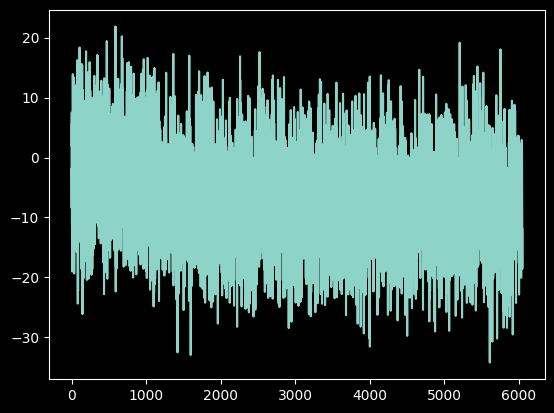

In [48]:
import matplotlib.pyplot as plt

plt.plot(values)